## **Quantum Computing for Option Pricing - Challenge Solution**

 ### Dependencies and imports 

We developed this solution within a conda environment (miniconda) running Python 3.11.2 and the following libraries: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.algorithms.optimizers import SPSA
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import step1
import step2
from step2 import CostFunction

### Understading Black-Scholes

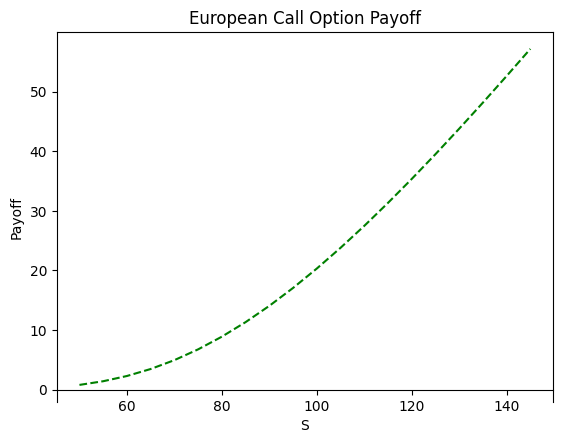

In [2]:
# Parameters
K = 100 # strike price
sigma = 0.4 # volatility in %
T= 1
r = 0.1
Smin = 50
Smax = 150

#Define range of stock price
S = np.arange(Smin,Smax,5)

#Define the underlying strike price
K = 100

fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(S, step1.black_scholes_european_call_payoff(S, K, T, r, sigma), '--', color='g')
plt.xlabel('S')
plt.ylabel('Payoff')
plt.title('European Call Option Payoff')
plt.show()

### **Step 1**: Build the ansatz circuit and the hamiltonian

For simplicity, we'll use the proposed ansatz:

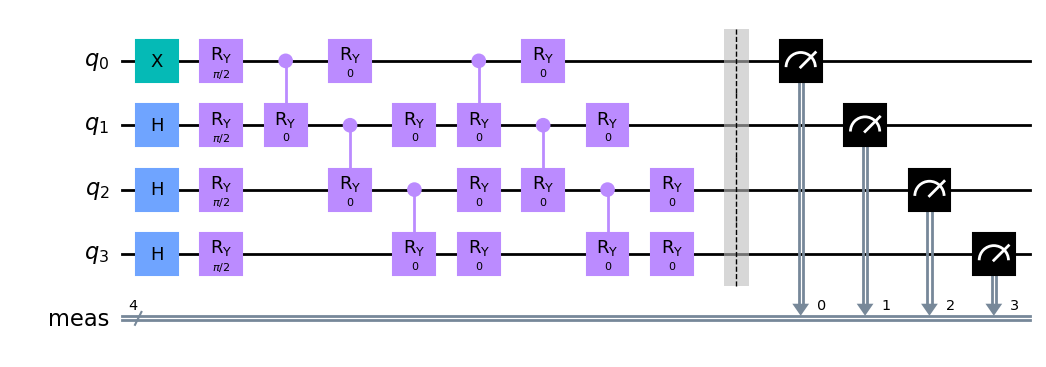

In [3]:
n_qbits=4
rep = 2

params = step1.get_init_params(n_qbits,rep)
qc = step1.ansatz(params,n_qbits,rep)

display(qc.draw('mpl'))


### **Step 2**: Build the initial state for the hybrid quantum-classical algorithm

9
[ 1.  4.  9. 16. 25. 36. 49. 64. 81.]
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.0, 7: 0.0035087719298245615, 8: 0.014035087719298246, 9: 0.031578947368421054, 10: 0.056140350877192984, 11: 0.08771929824561403, 12: 0.12631578947368421, 13: 0.17192982456140352, 14: 0.22456140350877193, 15: 0.28421052631578947}


/home/adria/miniconda3/envs/qiskit-hackathon/lib/python3.11/site-packages/qiskit/visualization/counts_visualization.py:384: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_ylim, min([1.1 * sum(all_vals), max(1.1 * val for val in all_vals)])])


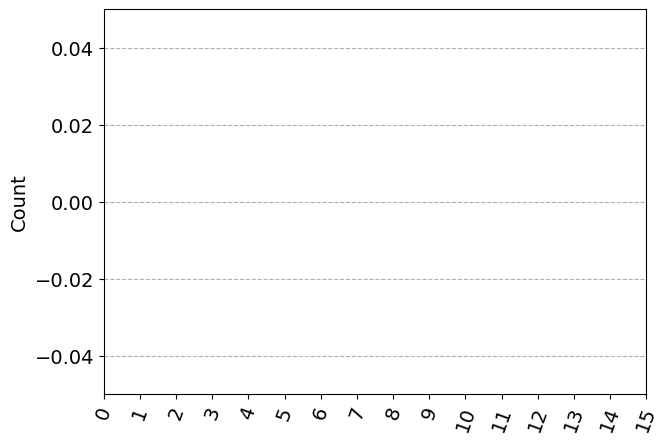

In [6]:
rep = 2
n_qbits = 4
params = step1.get_init_params(n_qbits, rep)
cross_over = 6
backend = Aer.get_backend('aer_simulator')
optimizer = SPSA(maxiter=1e3)
shots = 1e5
target_distr = step2.create_target_distr(n_qbits, cross_over)
print(target_distr)
display(plot_histogram(target_distr))

#cost_function = CostFunction(n_qbits,rep,backend,target_distr)

# optimization
#result = optimizer.minimize(fun=cost_function.return_cost_function,x0=params)



In [5]:
qc = step1.ansatz(result.x, n_qbits,rep)
qc_t = transpile(qc,backend)


final_result = backend.run(qc_t, shots=int(1e5)).result()
counts = final_result.get_counts()
display(plot_histogram(counts))

output_distr = step2.counts_to_distr(counts)
print(output_distr)

NameError: name 'result' is not defined

In [ ]:
fig, ax = plt.subplots()
ax.spines['bottom'].set_position('zero')
ax.plot(output_distr.keys(), output_distr.values(), '--', color='g')
plt.xlabel('S')
plt.ylabel('Payoff')
plt.title('European Call Option Payoff')
plt.show()

In [ ]:
# Obtain the output distribution using the final parameters

qc = step1.ansatz(result.x,n_qbits,rep)
qc_t = transpile(qc, backend)



In [ ]:
counts = backend.run(qc_t).result().get_counts()
display(plot_histogram(counts))

output_distr = counts_to_distr(counts)
print(output_distr)


### **Step 3**: Simulate the hybrid quantum-classical routine to price an European call option

### **Bonus points**:

- Run the hybrid quantum-classical on a QPU (optimize for given QPU connectivity). Reason whether you need state tomography, reason if possible to extract the information of interest (only the price call at the current date) with alternatives that require less expensive techniques. On a QPU or QASM  simulator, you only have access to short-estimated probabilities.

- Reason how to extend the algorithm to other type of options or to a multi-dimensional BS model.

- Implement Montecarlo or Finite differences schemes to solve the simple option pricing exercise. A classical baseline to compare with is useful. Argue where does the hybrid quantum algortihm stand in terms of error, runtime and numerical stability or others.